In [1]:
import tensorflow as tf
import numpy as np
import wfdb
import pywt

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
plt.style.use("seaborn")

In [2]:
sig_len = 1280

#### Helper functions

In [3]:
# Function to read the data from a given path to the .hea file
def read_data(path,type):
    signals, fields = wfdb.rdsamp(path,sampfrom=0)
    if(type=="normal"):
        data_array = signals.T[1]
    if(type=="cad"):
        data_array = signals.T[0]

    # Returns a data array of length that is a multiple of sig_len
    return data_array[:sig_len*int(data_array.shape[0]/sig_len)]

# Does wavelet transform to denoise the entire data array
def wavelet_transform(data_array):
    coefficient = pywt.wavedec(data_array,wavelet='db6',level=5)
    coefficient[0] = np.zeros_like(coefficient[0])
    transformed_signal = pywt.waverec(coefficient,wavelet='db6')

    data_array = transformed_signal

# Reshapes data array such that each row becomes signal segment of length sig_len
def reshape_data(data_array):
    return data_array.reshape(int(data_array.shape[0]/sig_len),sig_len)

# Does the preprocessing on the data segment of length sig_len
def augment_signal(data_array):
    # Normalization
    data_array = np.array((data_array-np.mean(data_array))/np.std(data_array))

    # Generate random sinusoidal noise signal
    starting_phase = np.random.uniform(-180, -90)
    # ending_phase = np.random.uniform(90, 180)      # I am not using this ending phase part here
    amplitude = np.random.uniform(-2, 2)
    time = np.arange(data_array.shape[0])  
    sinusoidal_noise_signal = amplitude * np.sin(2 * np.pi * time + np.radians(starting_phase))

    # Generate random Gaussian noise signal
    gaussian_noise_signal = np.random.normal(0, 0.05, len(data_array))

    data_array = data_array + sinusoidal_noise_signal + gaussian_noise_signal

# Converts the linear signal of shape (1280,) to an image of shape(211,24)
def make_img(data_array):
    result = []
    idx=0
    for i in range(0,24):
        result.append(data_array[idx:idx+211])
        idx+=40

    return np.array(result).T

#### Model

In [4]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(211,24)))
model.add(tf.keras.layers.Conv1D(filters=40,kernel_size=(5),strides=1))
model.add(tf.keras.layers.MaxPool1D(pool_size=2,strides=2,padding="valid"))
model.add(tf.keras.layers.Conv1D(filters=32,kernel_size=(3),strides=1))
model.add(tf.keras.layers.MaxPool1D(pool_size=2,strides=2,padding="valid"))
model.add(tf.keras.layers.LSTM(units=32,return_sequences=True,recurrent_dropout=0.25,dropout=0.5))
model.add(tf.keras.layers.LSTM(units=16,return_sequences=True,recurrent_dropout=0.25))
model.add(tf.keras.layers.LSTM(units=4,return_sequences=False))
model.add(tf.keras.layers.Dense(2,activation="softmax"))


'''   The model propsosed in the paper is below   '''
# model = tf.keras.Sequential()
# model.add(tf.keras.Input(shape=(211,24)))
# model.add(tf.keras.layers.Conv1D(filters=40,kernel_size=(5),strides=1))
# model.add(tf.keras.layers.MaxPool1D(pool_size=2,strides=2,padding="valid"))
# model.add(tf.keras.layers.Conv1D(filters=32,kernel_size=(3),strides=1))
# model.add(tf.keras.layers.MaxPool1D(pool_size=2,strides=2,padding="valid"))
# model.add(tf.keras.layers.LSTM(units=32,return_sequences=True,recurrent_dropout=0.25,dropout=0.5))
# model.add(tf.keras.layers.LSTM(units=16,return_sequences=True,recurrent_dropout=0.25))
# model.add(tf.keras.layers.LSTM(units=4,return_sequences=False))
# model.add(tf.keras.layers.Dense(1))

'   The model propsosed in the paper is below   '

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 207, 40)           4840      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 103, 40)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 101, 32)           3872      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 50, 32)           0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 50, 32)            8320      
                                                                 
 lstm_1 (LSTM)               (None, 50, 16)            3

In [6]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-6),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

# ,tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(),tf.keras.metrics.Recall()
# tf.keras.metrics.Accuracy(),

#### Reading the data

In [7]:
cad = {
    1: r"C:\Users\123na\Downloads\Heart Disease prediction\Data\CAD\I01",
    2: r"C:\Users\123na\Downloads\Heart Disease prediction\Data\CAD\I02"
}

normal = {
    1: r"C:\Users\123na\Downloads\Heart Disease prediction\Data\Healthy\f2y05",
    2: r"C:\Users\123na\Downloads\Heart Disease prediction\Data\Healthy\f2y08"
}

In [8]:
# Reading the data seperately to pick the proportion of the CAD and normal data 

# Reading the CAD data first
cad_data = []
cad_label = []
for idx in cad:
    # Read the data
    data = read_data(cad[idx],type="cad")

    # Performing wavelet transform on the entire data
    wavelet_transform(data)

    #Reshape data array
    data = reshape_data(data)
    for row in data:
        augment_signal(row)
        image = make_img(row)
        if(np.sum(np.isnan(image))==0): # We are getting some NaN values while reading data, we would just ignore data points that has NaN values
            cad_data.append(image)
            cad_label.append([1])

cad_data = np.array(cad_data)
cad_label = np.array(cad_label)



# Reading the normal data
normal_data = []
normal_label = []
for idx in normal:
    # Read the data
    data = read_data(normal[idx],type="normal")

    # Performing wavelet transform on the entire data
    wavelet_transform(data)

    #Reshape data array
    data = reshape_data(data)
    for row in data:
        augment_signal(row)
        image = make_img(row)
        if(np.sum(np.isnan(image))==0):  # We are getting some NaN values while reading data, we would just ignore those NaN producing elements
            normal_data.append(image)
            normal_label.append([0])

normal_data = np.array(normal_data)
normal_label = np.array(normal_label)

In [9]:
print(cad_data.shape,normal_data.shape)

# This is means that somehow only the normal_data had NaN values in it.

(722, 211, 24) (2769, 211, 24)


In [10]:
'''
There are 2784 samples in normal_data and 722 samples in cad_data, and the paper had used them in a ration of 9:1 respectively.

After filtering the NaN values we get 2769 and 722 data points respectively.

'''

np.random.shuffle(cad_data)       # Shuffling the data before taking a subset of the data
cad_data = cad_data[:600]         # Taking a subset of the data
cad_label = cad_label[:600]       # Taking the corresponding subset of labels

np.random.shuffle(normal_data)    # Shuffling the normal data also

In [11]:
# Combining the data and the labels by concatinating them
X = np.concatenate([cad_data,normal_data])
Y = np.concatenate([cad_label,normal_label])

In [12]:
# Schuffling the data final time

indices = np.arange(X.shape[0])
np.random.shuffle(indices)

X = X[indices]
Y = Y[indices]

Y = tf.keras.utils.to_categorical(Y)

In [13]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X,Y,test_size=0.2,shuffle=True)

In [14]:
Xtrain.shape

(2695, 211, 24)

In [15]:
print(np.sum(np.isnan(X)),np.sum(np.isnan(Y)))

0 0


In [16]:
np.where(np.isnan(X))

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))

#### Training the model

In [17]:
training_history = model.fit(Xtrain,Ytrain,epochs=30,verbose=True,batch_size=15)
# ,validation_split=0.15,shuffle=True

Epoch 1/30
180/180 [==============================] - 25s 74ms/step - loss: 0.6896 - binary_accuracy: 0.5898 - precision: 0.5898 - recall: 0.5896
Epoch 2/30
180/180 [==============================] - 14s 76ms/step - loss: 0.6877 - binary_accuracy: 0.6371 - precision: 0.6371 - recall: 0.6371
Epoch 3/30
180/180 [==============================] - 14s 77ms/step - loss: 0.6854 - binary_accuracy: 0.7072 - precision: 0.7072 - recall: 0.7072
Epoch 4/30
180/180 [==============================] - 13s 75ms/step - loss: 0.6838 - binary_accuracy: 0.7462 - precision: 0.7462 - recall: 0.7462
Epoch 5/30
180/180 [==============================] - 13s 73ms/step - loss: 0.6823 - binary_accuracy: 0.7725 - precision: 0.7725 - recall: 0.7725
Epoch 6/30
180/180 [==============================] - 14s 78ms/step - loss: 0.6808 - binary_accuracy: 0.8085 - precision: 0.8085 - recall: 0.8085
Epoch 7/30
180/180 [==============================] - 14s 78ms/step - loss: 0.6792 - binary_accuracy: 0.8419 - precision: 0.

In [18]:
model.evaluate(Xtest,Ytest)

22/22 [==============================] - 2s 12ms/step - loss: 0.6481 - binary_accuracy: 0.9629 - precision: 0.9629 - recall: 0.9629


[0.6481370329856873,
 0.9629080295562744,
 0.9629080295562744,
 0.9629080295562744]

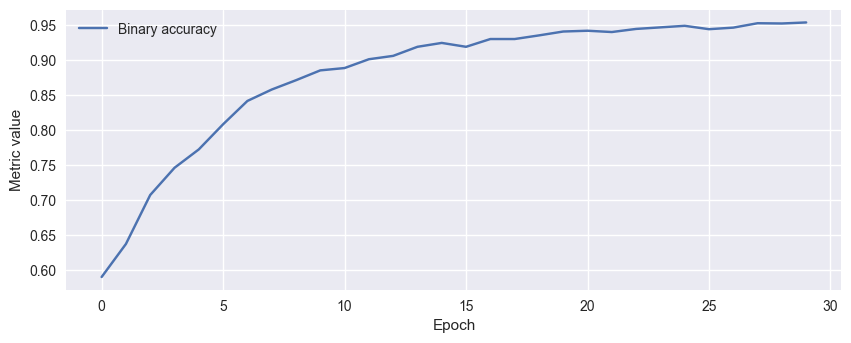

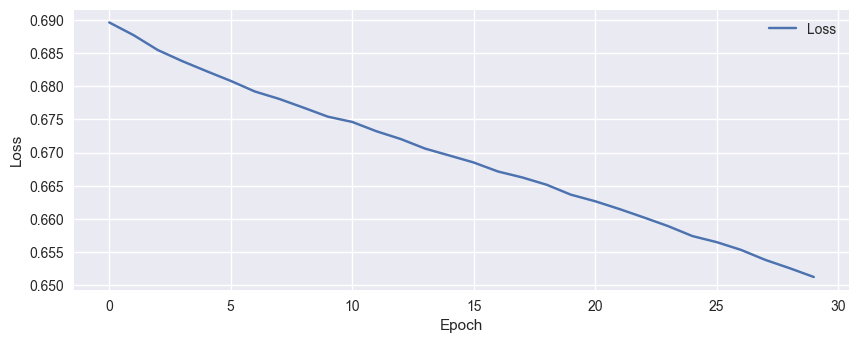

In [20]:
fig, ax = plt.subplots(figsize=(10,8))
plt.subplot(2,1,1)
plt.plot(training_history.history["binary_accuracy"],label="Binary accuracy")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Metric value")
plt.show()

fig, ax = plt.subplots(figsize=(10,8))
plt.subplot(2,1,2)
plt.plot(training_history.history["loss"],label="Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [21]:
model.save('CAD_detection_model_4ppl.h5')

In [22]:
test =tf.keras.models.load_model(r"C:\Users\123na\Downloads\Heart Disease prediction\Implementation\Code\CAD_detection_model_4ppl.h5")

In [24]:
test.evaluate(Xtrain,Ytrain)

85/85 [==============================] - 2s 28ms/step - loss: 0.6477 - binary_accuracy: 0.9599 - precision: 0.9599 - recall: 0.9599


[0.647736668586731, 0.9599257707595825, 0.9599257707595825, 0.9599257707595825]